In [328]:
import torch
import torch.optim as optim
import torch.random as random
from torch.utils import data
import time
import matplotlib.pyplot as plt
import numpy as np
import wandb
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

In [330]:
class LogisticRegression:
    def logistic_regression(self, X, w):
        return 1 / (1 + torch.exp(-torch.mv(X, w)))

    def loss(self, x, w, y):
        return (-torch.dot(
            y, torch.log(LogisticRegression.logistic_regression(self, x, w))
        ) - torch.dot(
            1 - y, torch.log(1 - LogisticRegression.logistic_regression(self, x, w))
        ))
    
    def lossval(self, x, w, y):
        return (-torch.dot(
            y, torch.log(LogisticRegression.logistic_regression(self, x, w))
        ) - torch.dot(
            1 - y, torch.log(1 - LogisticRegression.logistic_regression(self, x, w))
        ))/len(x)
    
    def weightdiff(self, w_hat, w_star):
        return (w_hat - w_star).norm()

    def quantization(self, w_hat):
        return ((w_hat > 0).float() - 0.5) * 2

In [331]:
def sgd(params, eps, alpha, step_size, batch_size):
    with torch.no_grad():
        for param in params:
            param -= step_size * param.grad / batch_size
            param.grad.zero_()

In [332]:
def speed(w, eps, alpha, sg, M):
    with torch.no_grad():
        sp = torch.zeros(len(w))
        psi = eps - (w**2 - 1) ** 2
        psid = -4 * (w**2 - 1) * w
        dirgrad = torch.logical_or(psi > 0, (-psid * sg) >= -alpha * psi)
        sp[dirgrad] = -sg[dirgrad]
        sp[~dirgrad] = torch.clip(-alpha * psi / psid, -M, M)[~dirgrad]
    return sp
def askewsgd(params, eps, alpha, step_size, batch_size):
    with torch.no_grad():
        for param in params:
            sg = param.grad / batch_size
            param += step_size * speed(param, eps, alpha, sg, 1)
            param.grad.zero_()

In [333]:
def newspeed(w, eps, alpha, sg, M):
    with torch.no_grad():
        sp = torch.zeros(len(w))
        psi = eps - (1 - w**2)
        psid = 2 * w
        dirgrad = torch.logical_or(psi > 0, (-psid * sg) >= -alpha * psi)
        sp[dirgrad] = -sg[dirgrad]
        sp[~dirgrad] = torch.clip(-alpha * psi / psid, -M, M)[~dirgrad]
    return sp
def newaskewsgd(params, eps, alpha, step_size, batch_size):
    with torch.no_grad():
        for param in params:
            sg = param.grad / batch_size
            param += step_size * newspeed(param, eps, alpha, sg, 1)
            param.grad.zero_()

In [334]:
def hard_sigmoid(w):
    return torch.clip((w + 1) / 2, 0, 1)
def binarize(w):
    wb = (torch.bernoulli(hard_sigmoid(w)) - 0.5) * 2
    return wb
def bcsgd(params, eps, alpha, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            torch.clip(param, -1, 1)
            param.grad.zero_()

In [335]:
def qste(w):
    return torch.where(torch.logical_or(w>1, w<-1) == True, 0, 1)
def ste(params, eps, alpha, lr, batch_size):
    with torch.no_grad():
        for param in params:
            d = qste(param)
            param -= lr * d * param.grad / batch_size
            param.grad.zero_()

In [336]:
def load_array(features, labels, batch_size, is_train=True):
    dataset = data.TensorDataset(features, labels)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [337]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [338]:
class ModelTrainerExperiment1:
    def __init__(self, n_train, n_test, dim):
        # activate CUDA
        device = "cuda" if torch.cuda.is_available() else "cpu"
        # generate data
        self.n_train = n_train
        self.n_test = n_test
        self.n = n_train + n_test
        self.dim = dim
        self.w_star = (torch.rand(dim) - 0.5).sign()
        self.X = torch.rand(self.n, dim)
        self.Y = torch.bernoulli(1.0 / (1 + torch.exp(-torch.mv(self.X, self.w_star))))
        self.X_train, self.Y_train = self.X[:n_train], self.Y[:n_train]
        self.X_test, self.Y_test = self.X[n_train:], self.Y[n_train:]
        self.w_init = torch.zeros(dim)
        # net = LogisticRegression()
        # print(LogisticRegression.loss(net, self.X_train, self.w_star, self.Y_train))

    def train(self, ax, optimizer, batch_size, num_epoch, decay_epochs, k=0.88, alpha=0, lr=0, lr_decay=1):
        net = LogisticRegression()
        w_hat = self.w_init.clone()
        w_hat.requires_grad_()
        loss = []
        weight_loss = []
        quantized_loss = []
        batch_gradient = []
        data_iter = load_array(self.X_train, self.Y_train, batch_size)
        opti = optimizer
        for epoch in range(num_epoch):
            if epoch < 50:
                eps = 1
            else:
                eps = k ** (epoch - 50)
            if epoch in decay_epochs:
                lr *= lr_decay
            for X, y in data_iter:
                if optimizer == bcsgd or optimizer == ste:
                    with torch.no_grad():
                        wb = binarize(w_hat)
                    wb.requires_grad_()
                    l = LogisticRegression.loss(net, X, wb, y)
                    l.backward()
                    w_hat.grad = wb.grad
                else:
                    l = LogisticRegression.loss(net, X, w_hat, y)
                    l.backward()

                opti([w_hat], eps, alpha, lr, len(X))
                l = LogisticRegression.lossval(net, self.X_train, w_hat, self.Y_train)
                l.backward()
                batch_gradient.append(w_hat.grad.norm())
                w_hat.grad.zero_()
                with torch.no_grad():
                    loss.append(
                        LogisticRegression.lossval(net, X, w_hat, y)
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    weight_loss.append(
                        LogisticRegression.weightdiff(net, w_hat, self.w_star)
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    quantized_loss.append(
                        LogisticRegression.lossval(
                            net, X, LogisticRegression.quantization(net, w_hat), y
                        )
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    if optimizer == askewsgd or optimizer == bcsgd or optimizer == ste:
                        w_hat.data.clamp_(-1, 1)
                wandb.log(
                    {
                        "loss": loss[-1],
                        "weight_loss": weight_loss[-1],
                        "quantized_loss": quantized_loss[-1],
                        "batch_gradient": batch_gradient[-1],
                    }
                )

        ax.set_xlabel(r"Iterations", fontsize=16)
        ax.set_ylabel(r"d(w_hat, w)", fontsize=16)
        ax.plot(weight_loss)
        return loss, weight_loss, quantized_loss, batch_gradient

batch_gradient,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▅▆▆▆▃▅▄▄▃▇▆▂▃▃▅▄▅▃▄▃▂▄▃▆▆▁▃▂▄▃▄▂▃▃▆▄▂▁
quantized_loss,█▆▇██▅▂▂▂▁▁▂▂▁▂▁▂▂▂▁▂▁▁▂▁▂▂▁▂▁▂▂▂▁▂▁▂▂▁▁
weight_loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch_gradient,0.00533
loss,0.38862
quantized_loss,0.38942
weight_loss,0.5125


batch_gradient,█▅▄▄▃▃▃▃▃▃▃▂▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁
loss,██▅▇▅▃▄▄▃▅▇▄▆▂▁▆▅▅▃▄▅▂▇▅▃▁▃▂▃▅▃▁▄▄▄▅▁▃▂▄
quantized_loss,██▇█▁▁▁▁▁▂▂▁▂▁▁▂▂▂▁▁▂▁▂▂▁▁▁▁▁▂▁▁▂▂▂▂▁▁▁▂
weight_loss,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_gradient,0.00331
loss,0.39843
quantized_loss,0.39951
weight_loss,0.32236


batch_gradient,█▅▄▄▄▃▃▃▃▃▂▃▂▂▂▃▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▅▅▇▅▆▆▄▄▆▆▅▃▅▆▄▃▄▃▃▁▃▆▅▇▁▅▅▄▂▅▄▂▃▇▄▂▆▁
quantized_loss,██▇▇▁▁▂▂▁▁▂▂▂▁▂▂▁▁▂▁▁▁▁▂▂▂▁▂▂▂▁▂▂▁▁▂▁▁▂▁
weight_loss,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_gradient,0.00392
loss,0.36985
quantized_loss,0.36985
weight_loss,0.32661


batch_gradient,█▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
loss,█▅▇▇▆▅▄█▄▇▃▅▂▄▃▅▅▃▃▁▇▄▅▄▅▄▂▆▃▃▅▃▄▄▆▃▅▂▅▅
quantized_loss,▇▆▇█▂▁▁▂▁▂▁▂▁▂▁▂▂▁▁▁▂▂▂▂▂▂▁▂▁▁▂▁▂▂▂▁▂▁▂▂
weight_loss,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_gradient,0.00311
loss,0.40647
quantized_loss,0.40777
weight_loss,0.32727


batch_gradient,▅▇▃▄▅▃▃▆▁▇█▆▅▅▅▄▅▂▃▅▅▆▆▃▂▃▂▄▄▃▃▃▄▃▂▂▃▃▃▁
loss,▆▇▅▄▅▆▅▆▄▆█▄▅▄▃▄▅▄▃▄▄▅▄▄▅▁▂▅▅▅▄▄▃▄▂▄▅▃▄▄
quantized_loss,███▇█▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▁▂▂▂▂▂
weight_loss,██▇▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
batch_gradient,0.02623
loss,0.39925
quantized_loss,0.39967
weight_loss,0.37915


batch_gradient,█▄▃▄▄▃▄▃▃▄▄▃▂▁▂▃▃▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇█▅▅▅▄▅▄▃▇▆▄▂▃▁▂▃▄▃▂▂▂▂▂▂▃▁▂▃▃▁▃▂▂▂▂▂▃▂▂
quantized_loss,▆▇█▆▇▅▆▂▁▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▂▂▁▂▁▁▁▁▁▂▁▁
weight_loss,██▇▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_gradient,0.03438
loss,0.39838
quantized_loss,0.39601
weight_loss,0.18103


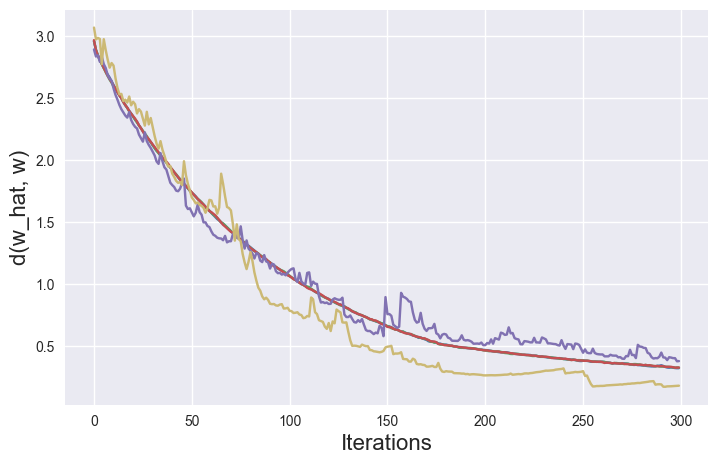

In [340]:
trainer = ModelTrainerExperiment1(n_train=6000, n_test=1000, dim=10)
num_epoch = 50
batch_size = 1000
decay_epoch = [30, 60]
# Using seaborn's style
plt.style.use("seaborn")
width = 600
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="exp",
    name="ASkewSGD_0.5",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "ASkewSGD_0.5",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
# simulate training

ModelTrainerExperiment1.train(
    trainer, ax, askewsgd, batch_size=batch_size, num_epoch=num_epoch, decay_epochs=decay_epoch, alpha=0.1, lr=1, lr_decay=0.5
)
wandb.finish()
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="exp",
    name="newASkewSGD_0.5",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "ASkewSGD_0.5",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
# simulate training

ModelTrainerExperiment1.train(
    trainer, ax, newaskewsgd, batch_size=batch_size, num_epoch=num_epoch, decay_epochs=decay_epoch, alpha=0.1, lr=1, lr_decay=0.5
)
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="exp",
    name="SGD",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "SGD",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
ModelTrainerExperiment1.train(trainer, ax, sgd, batch_size=batch_size, decay_epochs=decay_epoch, num_epoch=num_epoch, lr=1, lr_decay=0.5)
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="exp",
    name="BinaryConnect",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "BinaryConnect",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
ModelTrainerExperiment1.train(trainer, ax, bcsgd, batch_size=batch_size, decay_epochs=decay_epoch, num_epoch=num_epoch, lr=1, lr_decay=0.5)
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="exp",
    name="STE",
    # track hyperparameters and run metadata
    config={
        "batch_size": 1000,
        "architecture": "StraightThroughEstimator",
        "dataset": "LogisticRegression",
        "epochs": 50,
    },
)
ModelTrainerExperiment1.train(trainer, ax, ste, batch_size=batch_size, num_epoch=num_epoch, decay_epochs=decay_epoch, lr=1, lr_decay=0.5)
wandb.finish()
fig.savefig("weight_loss_logisticregression.pdf", format="pdf", bbox_inches="tight")